In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pysindy as ps

import pickle as pkl
import time
import os

from scipy.integrate import solve_ivp
from numpy import random

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12 # set relative tolerance
integrator_keywords['method'] = 'LSODA' # Livermore Solver for Ordinary Differential Equations with Automatic Stiffness Adjustment
integrator_keywords['atol'] = 1e-12 # set absolute tolerance

In [2]:
# to include in Yukawa_SINDy.py as another child class
import importlib
import Yukawa_SINDy
importlib.reload(Yukawa_SINDy) # imports Yukawa_SINDy separately everytime (?)

# create new Simulation object to simulate 3-body system
class Yukawa3body(Yukawa_SINDy.Simulation):
    ###############################################################################################
    # Class Constructor
    ###############################################################################################

    def __init__(self, potential_type = "repulsive", rng=None):
        super().__init__()
        self.init_cond = [0, 1e-2, 0, 1e-2,   1, -1e-2, 0, 1e-2,   0, 1e-2, 1, -1e-2] # default values are bad, need to pull new ones at some point
        self.labels = np.array([(f"x{i}", f"vx{i}", f"y{i}", f"vy{i}") for i in range(3)]).reshape((12,))
        
        self.is_subtracted = False
        self.x_subtracted = None
        # str var potential can be 'attractive' or 'repulsive'.
        if potential_type != 'attractive' or potential_type != 'repulsive':
            self.potential_type = potential_type
        else:
            raise ValueError("attribute 'potential_type' must be either str 'attractive' or 'repulsive'")
        # construct rng for class instance
        if rng is None: # create rng if none given
            seed_rng = np.random.default_rng()
            seed_num = seed_rng.integers(10000,100000)
            self.seed_num = seed_num
            rng = np.random.default_rng(seed=seed_num)
            self.rng = rng
        else: # use rng if passed as an arg
            self.rng = rng

    ###############################################################################################
    # Getters and setters
    ###############################################################################################

    @property
    def init_cond(self):
        return self._init_cond
    @init_cond.setter
    def init_cond(self, init_cond):
        self._init_cond = init_cond

    @property
    def labels(self):
        return self._labels
    @labels.setter
    def labels(self, labels):
        self._labels = labels

    @property
    def x_subtracted(self):
        return self._x_subtracted
    @x_subtracted.setter
    def x_subtracted(self, x_subtracted):
        self._x_subtracted = x_subtracted

    @property
    def potential_type(self):
        return self._potential_type
    @potential_type.setter
    def potential_type(self, potential_type):
        self._potential_type = potential_type

    ###############################################################################################
    # Class Methods
    ###############################################################################################

    def Yukawa_3body_EOM(self,t, x):
        '''
        Description: 
            this is the equations of motion for a 3-body system in 2 dimensions. The particle indices in this case are 
            0, 1, and 2. The equations of motion are coded below in first order form, which means the 2nd order ODE is
            split into 2 first order ODEs. Therefore, we have 12 first order ODEs. Half of these, though, are the
            trivial relation of d/dt (xi) = (vxi), and the other half are the equations of motion of the form 
            d/dt (vxi) = f(x0,x1,x2). Let the position of the ith particle be given by (xi, yi) and the velocity by 
            (vxi, vyi). The data is stored in the numpy array as follows:

            x[0] = x0, 
            x[1] = vx0, 
            x[2] = y0, 
            x[3] = vy0, 

            x[4] = x1, 
            x[5] = vx1, 
            x[6] = y1,  
            x[7] = vy1, 

            x[8] = x2, 
            x[9] = vx2, 
            x[10] = y2, 
            x[11] = vy2
        '''
        # str var potential can be 'attractive' or 'repulsive'.
        if self.potential_type == 'attractive':
            a = -1
        elif self.potential_type == 'repulsive':
            a = 1
        else:
            raise ValueError("attribute 'potential_type' must be either str 'attractive' or 'repulsive'")
        
        return [## PARTICLE 1
                # x
                x[1],
                a*(x[ 0] - x[ 4]) * np.exp( -np.sqrt( (x[ 0] - x[ 4])**2 + (x[ 2] - x[ 6])**2 ) ) * ( ( (x[ 0] - x[ 4])**2 + (x[ 2] - x[ 6])**2 )**(-1) + ( (x[ 0] - x[ 4])**2 + (x[ 2] - x[ 6])**2 )**(-3/2) ) + # 12 interaction
                a*(x[ 0] - x[ 8]) * np.exp( -np.sqrt( (x[ 0] - x[ 8])**2 + (x[ 2] - x[10])**2 ) ) * ( ( (x[ 0] - x[ 8])**2 + (x[ 2] - x[10])**2 )**(-1) + ( (x[ 0] - x[ 8])**2 + (x[ 2] - x[10])**2 )**(-3/2) ), # 13 interaction
                # y
                x[3],
                a*(x[ 2] - x[ 6]) * np.exp( -np.sqrt( (x[ 0] - x[ 4])**2 + (x[ 2] - x[ 6])**2 ) ) * ( ( (x[ 0] - x[ 4])**2 + (x[ 2] - x[ 6])**2 )**(-1) + ( (x[ 0] - x[ 4])**2 + (x[ 2] - x[ 6])**2 )**(-3/2) ) + # 12 interaction
                a*(x[ 2] - x[10]) * np.exp( -np.sqrt( (x[ 0] - x[ 8])**2 + (x[ 2] - x[10])**2 ) ) * ( ( (x[ 0] - x[ 8])**2 + (x[ 2] - x[10])**2 )**(-1) + ( (x[ 0] - x[ 8])**2 + (x[ 2] - x[10])**2 )**(-3/2) ) , # 13 interaction
                ## PARTICLE 2
                # x
                x[5],
                a*(x[ 4] - x[ 8]) * np.exp( -np.sqrt( (x[ 4] - x[ 8])**2 + (x[ 6] - x[10])**2 ) ) * ( ( (x[ 4] - x[ 8])**2 + (x[ 6] - x[10])**2 )**(-1) + ( (x[ 4] - x[ 8])**2 + (x[ 6] - x[10])**2 )**(-3/2) ) + # 23 interaction
                a*(x[ 4] - x[ 0]) * np.exp( -np.sqrt( (x[ 4] - x[ 0])**2 + (x[ 6] - x[ 2])**2 ) ) * ( ( (x[ 4] - x[ 0])**2 + (x[ 6] - x[ 2])**2 )**(-1) + ( (x[ 4] - x[ 0])**2 + (x[ 6] - x[ 2])**2 )**(-3/2) ) , # 21 interaction
                # y
                x[7],
                a*(x[ 6] - x[10]) * np.exp( -np.sqrt( (x[ 4] - x[ 8])**2 + (x[ 6] - x[10])**2 ) ) * ( ( (x[ 4] - x[ 8])**2 + (x[ 6] - x[10])**2 )**(-1) + ( (x[ 4] - x[ 8])**2 + (x[ 6] - x[10])**2 )**(-3/2) ) + # 23 interaction
                a*(x[ 6] - x[ 2]) * np.exp( -np.sqrt( (x[ 4] - x[ 0])**2 + (x[ 6] - x[ 2])**2 ) ) * ( ( (x[ 4] - x[ 0])**2 + (x[ 6] - x[ 2])**2 )**(-1) + ( (x[ 4] - x[ 0])**2 + (x[ 6] - x[ 2])**2 )**(-3/2) ) , # 21 interaction
                ## PARTICLE 3
                # x
                x[9],
                a*(x[ 8] - x[ 0]) * np.exp( -np.sqrt( (x[ 8] - x[ 0])**2 + (x[10] - x[ 2])**2 ) ) * ( ( (x[ 8] - x[ 0])**2 + (x[10] - x[ 2])**2 )**(-1) + ( (x[ 8] - x[ 0])**2 + (x[10] - x[ 2])**2 )**(-3/2) ) + # 31 interaction
                a*(x[ 8] - x[ 4]) * np.exp( -np.sqrt( (x[ 8] - x[ 4])**2 + (x[10] - x[ 6])**2 ) ) * ( ( (x[ 8] - x[ 4])**2 + (x[10] - x[ 6])**2 )**(-1) + ( (x[ 8] - x[ 4])**2 + (x[10] - x[ 6])**2 )**(-3/2) ) , # 32 interaction
                # y
                x[11],
                a*(x[10] - x[ 2]) * np.exp( -np.sqrt( (x[ 8] - x[ 0])**2 + (x[10] - x[ 2])**2 ) ) * ( ( (x[ 8] - x[ 0])**2 + (x[10] - x[ 2])**2 )**(-1) + ( (x[ 8] - x[ 0])**2 + (x[10] - x[ 2])**2 )**(-3/2) ) + # 31 interaction
                a*(x[10] - x[ 6]) * np.exp( -np.sqrt( (x[ 8] - x[ 4])**2 + (x[10] - x[ 6])**2 ) ) * ( ( (x[ 8] - x[ 4])**2 + (x[10] - x[ 6])**2 )**(-1) + ( (x[ 8] - x[ 4])**2 + (x[10] - x[ 6])**2 )**(-3/2) )   # 32 interaction
                ]
    

    def simulate(self, duration, dt=1e-4, func=Yukawa_3body_EOM, potential_type:str="repulsive"):
        '''
        Description:
            Uses scipy.integrate.solve_ivp to simulate the system of equations given by argument 'func'.
        '''
        # if self.init_cond==[0, 1e-2, 0, 1e-2,   1, -1e-2, 0, 1e-2,   0, 1e-2, 1, -1e-2]:
        #     print("using default initial conditions")
        # above not working for some reason
        
        # create time grid
        t = np.arange(0,duration+dt,dt)
        t_span = (t[0], t[-1])

        # input only vars t and x into the solve_ivp function call, set potential_type
        func_to_solve = lambda t,x: func(self,t,x)

        # solve initial value problem and return trajectories
        x_clean = solve_ivp(func_to_solve, t_span, self.init_cond, t_eval=t, **integrator_keywords).y.T
        # save parameters as attributes
        
        self.duration = duration
        self.dt = dt
        # save data as attributes
        self.t=t
        self.x=x_clean


    def generate_init_cond(self, std_dev=0.1, print=False):
        '''
        Description:
            Creates random initial conditions to use in the simulation. Note: if not run before method "simulate()", 
            simulation will use default initial conditions. In the case of an attractive potential, all the initial
            positions and velocities are drawn at random from a normal distribution centered at the origin with a 
            standard deviation of std_dev. In the case of a repulsive potential, the initial positions are drawn from a 
            normal distribution centered at the origin with a standard deviation of std_dev, and the initial velocities
            are calculated from those positions such that they point radially inward towards the origin.
        '''
        
        # Attractive case:
        # create random initial conditions from normal distribution centered at the origin with standard deviation 
        # std_dev
        if self.potential_type == "attractive":
            init_cond = self.rng.normal(0.0, std_dev, (12,))
            # save as attribute
            self.init_cond = init_cond

        # Repulsive case:
        # create random initial positions from normal distribution as before, and calculate
        elif self.potential_type == "repulsive":
            pos_init_cond = self.rng.normal(0, std_dev, (6,))
            vel_init_cond = self.__calculate_vel_init_cond(pos_init_cond)
            init_cond_list = []
            # combine position and velocity initial conditions into one numpy array
            for i in range(len(pos_init_cond)):
                init_cond_list.append(pos_init_cond[i])
                init_cond_list.append(vel_init_cond[i])
            init_cond = np.array(init_cond_list)
            self.init_cond = init_cond
            
        if print:
            print("initial conditions are now set to:")
            [print(self.labels[i] + " = " + str(init_cond[i])) for i in range(len(init_cond))]
            print()


    def __calculate_vel_init_cond(self,pos_init_cond:np.ndarray):
        '''
        Description: calculate initial velocity vectors such that all point radially inward
        towards the origin
        '''
        # updated code:
        # calculate angle from the positive x-axis in radians on the int [-pi,pi]
        angles = np.arctan2(pos_init_cond[1::2],pos_init_cond[0::2])
        # calculate initial velocity using angle
        vel_init_cond = []
        for i in range(angles.shape[0]):
            speed = 10 # self.rng.random() # should change to random once I get it working
            # append negative of calculated x- and y-components to list for init vels
            vel_init_cond.append(-speed*np.cos(angles[i]))
            vel_init_cond.append(-speed*np.sin(angles[i]))
        return vel_init_cond


    def plot(self, which:str='position'):
        if which == 'position':
            loop_start = 0
        elif which == 'velocity':
            loop_start = 1
        else:
            raise ValueError("str var which must be either 'position' or 'velocity'")
        # visualize trajectories
        fig, ax = plt.subplots(1,1, figsize=(10,10))
        colors = ['C0','C1','C2']

        # plot x- and y-axes
        # ax.axhline(0, color='black', linewidth=.5)
        # ax.axvline(0, color='black', linewidth=.5)

        # plot trajectories
        for i in range( loop_start, self.x.shape[1], 4 ):
            label = f"particle {i//4}"
            # plot particle trajectories
            ax.plot(self.x[:,i], self.x[:,i+2], colors[i//4], label=label)
            # plot dots for ptcl init position
            ax.plot(self.init_cond[i],self.init_cond[i+2], colors[i//4] + 'o', label=label + " start")
        ax.legend()
        fig.tight_layout()


    def subtract_data(self,x_simulated):
        # generate repeated list of indices
        idxs = np.tile(np.arange(0,12),2)
        # transform labels and data to be subtracted as explained above
        x_subtracted_labels = np.hstack([self.labels[i] + "-" + self.labels[j] for i,j in zip(idxs[:12],idxs[4:])])
        x_subtracted = np.vstack([self.x[:,i]-self.x[:,j] for i,j in zip(idxs[:12],idxs[4:])]).T
        return x_subtracted, x_subtracted_labels
    

    def save_data(self, directoryname:str='data'):
        # create filename using date and time
        timestr = time.strftime("%Y%m%d_%H%M%S")
        filename = f"{directoryname}/Yukawa3body_{timestr}.obj"
        # save data to file
        counter = 0
        filename_to_check = filename
        while os.path.exists(filename_to_check):
            counter += 1
            filename_to_check = filename[:-4] + f"_{counter}.obj"
            print(filename_to_check)
        print(filename_to_check) 
        with open(filename_to_check, 'wb') as f:
            pkl.dump(self, f)


# END CLASS
######################################################################################################


######################################################################################################
# Functions
######################################################################################################

def multiple_simulate(duration=3e-1, dt=1e-4, n_trajectories=10, potential_type:str='attractive', rng=None):
    # desc: simulate n_trajectories of equal duration trajectories with different random initial 
    # conditions, returns list of Yukawa3body objects
    default_seed = 346734
    if rng is None:
        rng = np.random.default_rng(seed=default_seed)

    sim_list = []
    for i in range(n_trajectories):
        print("calculating trajectory", i)
        # randomize initial conditions and append to list
        sim = Yukawa3body(potential_type=potential_type, rng=rng)
        sim.generate_init_cond()
        sim.simulate(duration,dt=dt)
        sim_list.append(sim)
    return sim_list


def plot_multiple(sim_list:list, which:str='position'):
    '''
    Description: plots first 9 trajectories of x
    Inputs:
        sim_list: list of sim objects

    '''
    # desc: plots first 9 trajectories of x
    # identify which to plot using string var 'which'
    if which == 'position':
        loop_start = 0
    elif which == 'velocity':
        loop_start = 1
    else:
        raise ValueError("kwarg which which must be either 'position' or 'velocity'")
    # plot first 9 trajectories of x
    fig, axs = plt.subplots(3,3, figsize=(20,20))
    colors = ['C0','C1','C2']
    axs.resize((9,))
    for i in range(9):
        for j in range( loop_start, sim_list[0].x.shape[1], 4 ):
            label = f"particle {j//4}"
            # plot particle trajectories
            axs[i].plot(sim_list[i].x[:,j], sim_list[i].x[:,j+2], colors[j//4], label=label)
            # plot dots for ptcl init position
            axs[i].plot(sim_list[i].init_cond[j],sim_list[i].init_cond[j+2], colors[j//4] + 'o')#, label=label + " start")
            # plot arrows for ptcl init velocity
            # axs[i].arrow(sim_list[i].init_cond[j],sim_list[i].init_cond[j+2],5e-2*sim_list[i].init_cond[j+1],5e-2*sim_list[i].init_cond[j+3], color=colors[j//4], width=0.0005)#, label=label + " init. vel.")
        axs[i].legend()
    fig.tight_layout()

In [3]:
sim_list = multiple_simulate()

calculating trajectory 0
calculating trajectory 1
calculating trajectory 2
calculating trajectory 3
calculating trajectory 4
calculating trajectory 5
calculating trajectory 6
calculating trajectory 7
calculating trajectory 8
calculating trajectory 9


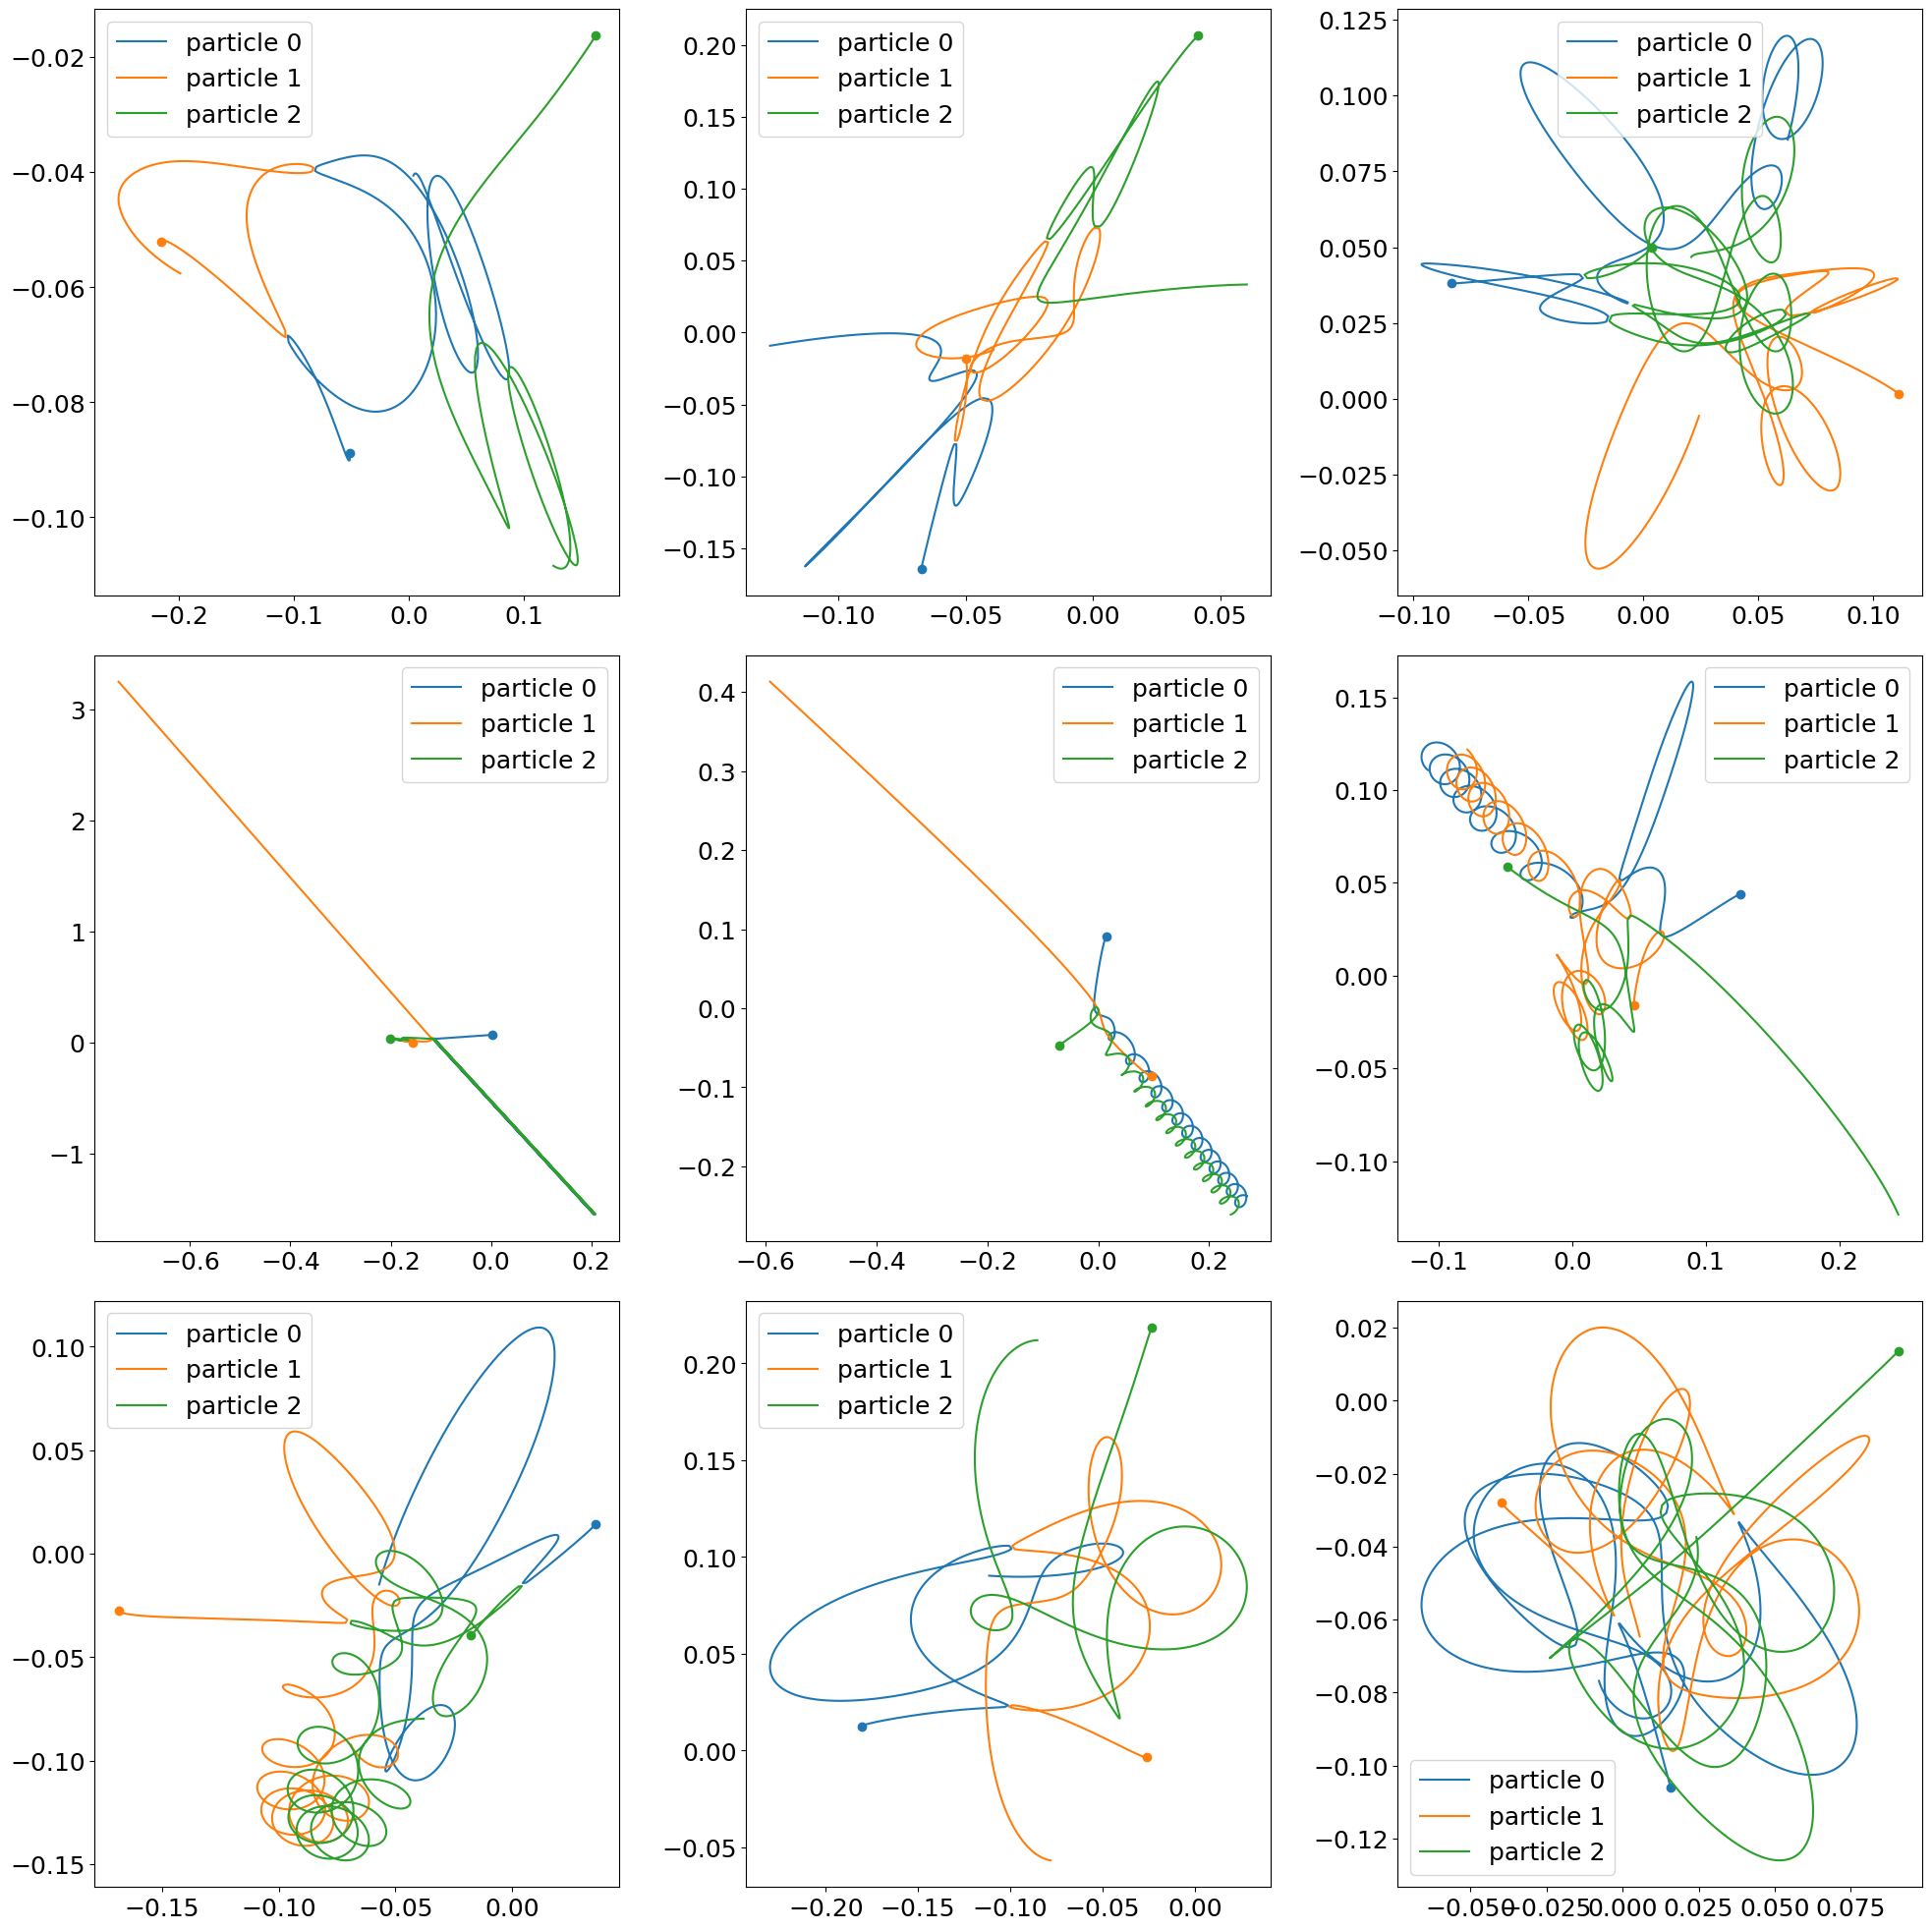

In [5]:
plot_multiple(sim_list)

In [4]:
for sim in sim_list:
    print("saving data for trajectory", sim_list.index(sim))
    sim.save_data(directoryname="data/test")
    # time.sleep(1)

saving data for trajectory 0
data/test/Yukawa3body_20250418_165528.obj
saving data for trajectory 1
data/test/Yukawa3body_20250418_165528_1.obj
data/test/Yukawa3body_20250418_165528_1.obj
saving data for trajectory 2
data/test/Yukawa3body_20250418_165528_1.obj
data/test/Yukawa3body_20250418_165528_2.obj
data/test/Yukawa3body_20250418_165528_2.obj
saving data for trajectory 3
data/test/Yukawa3body_20250418_165528_1.obj
data/test/Yukawa3body_20250418_165528_2.obj
data/test/Yukawa3body_20250418_165528_3.obj
data/test/Yukawa3body_20250418_165528_3.obj
saving data for trajectory 4
data/test/Yukawa3body_20250418_165528_1.obj
data/test/Yukawa3body_20250418_165528_2.obj
data/test/Yukawa3body_20250418_165528_3.obj
data/test/Yukawa3body_20250418_165528_4.obj
data/test/Yukawa3body_20250418_165528_4.obj
saving data for trajectory 5
data/test/Yukawa3body_20250418_165528_1.obj
data/test/Yukawa3body_20250418_165528_2.obj
data/test/Yukawa3body_20250418_165528_3.obj
data/test/Yukawa3body_20250418_16552

In [33]:
for sim in sim_list:
    print("saving data for trajectory", sim_list.index(sim))
    sim.save_data(directoryname="data/test")
    # time.sleep(1)

saving data for trajectory 0


PicklingError: Can't pickle <class '__main__.Yukawa3body'>: it's not the same object as __main__.Yukawa3body